In [1]:
import os
import re
import time
import glob
import json
import random
import subprocess
import soundfile as sf
import argparse
import warnings

import pandas as pd
import numpy as np
import librosa
import librosa.display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from functools import partial

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model

def seed_everything(SEED):
   random.seed(SEED)
   np.random.seed(SEED)
   tf.random.set_seed(SEED)
   print("Random seed set.")

seed_everything(SEED=42)
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
main_dir = r"Datasets\TIMIT-dataset\data"

Random seed set.


# Preprocessing

In [2]:
# wav_paths = [path for path in glob.glob(main_dir + "/*/*/*.wav") 
#     if not (path.endswith("_1.wav") or path.endswith("_2.wav"))]
# frames = [len(librosa.load(wav_path, sr=16000)[0]) for wav_path in wav_paths]
# print("Max frames:", np.max(frames))

# plt.figure(figsize=(10,4))
# sns.histplot(data=frames)
# plt.axvline(x=np.mean(frames), color='red')
# plt.xlabel("Number of frames per sample")
# plt.show()

## Clip non-verbal units

In [3]:
def Clip(wav_paths, clip_buffer=320):
    for wav_path in tqdm(wav_paths, desc='Clip'):
        phn_path = wav_path.replace(".wav", ".phn")
        lines = open(phn_path, "r").readlines()
        y = librosa.load(wav_path, sr=16000)[0]
        y_1 = len(y)

        # First line
        start, end, phoneme = lines[0].split()
        if phoneme == "h#":
            if int(end) > clip_buffer:
                clip_factor = int(end) - clip_buffer
                y = y[clip_factor::]
                for i, line in enumerate(lines):
                    start, end, phoneme = line.split()
                    start = int(start) - clip_factor
                    end = int(end) - clip_factor
                    lines[i] = f"{max(0, start)} {end} {phoneme}\n"

        # Middle lines
        phonemes = np.array([line.split()[-1] for line in lines[1:-1]])
        cond_1 = (phonemes == "pau") | (phonemes == "sil") | (phonemes == "epi")
        for i in np.where(cond_1)[0]:
            start, end, phoneme = lines[i].split()
            start, end = int(start), int(end)
            delta = end - start
            clip_factor = delta - clip_buffer
            if delta >= clip_buffer:
                new_end = int(end) - clip_factor
                lines[i] = f"{start} {new_end} {phoneme}\n"
                y = np.concatenate((y[:new_end], y[end:]), axis=0)
                for j in range(i+1, len(lines)):
                    start, end, phoneme = lines[j].split()
                    start = int(start) - clip_factor
                    end = int(end) - clip_factor
                    lines[j] = f"{start} {end} {phoneme}\n"

        # Last line
        start, end, phoneme = lines[-1].split()
        if phoneme == "h#":
            delta = int(end) - int(start)
            if delta > clip_buffer:
                end = int(start) + clip_buffer
                lines[-1] = f"{start} {end} {phoneme}\n"
                y = y[:end]
    
        with open(phn_path, "w") as f:
            f.writelines(lines)

        sf.write(wav_path, y, 16000)

# Clip(wav_paths)

In [4]:
# wav_paths = [path for path in glob.glob(main_dir + "/*/*/*.wav") 
#     if not (path.endswith("_1.wav") or path.endswith("_2.wav"))]
# frames = [len(librosa.load(wav_path, sr=16000)[0]) for wav_path in wav_paths]
# print("Max frames:", np.max(frames))

# plt.figure(figsize=(10,4))
# sns.histplot(data=frames)
# plt.axvline(x=np.mean(frames), color='red')
# plt.xlabel("Number of frames per sample")
# plt.show()

## Discretize phoneme classes

In [5]:
def Discretize(wav_paths):
    vowels = [
        "iy", "ih", "eh", "ay", "ae", "aa", "aw", "ay", "ah", "ao", "oy", "ow",
        "uh", "uw", "er", "ax", "axr"]
    merge_dict = {
        "em": "m", "eng": "ng", "en": "n", "dx": "d", "nx": "n", "el": "l", 
        "hv": "hh", "ux": "uw", "ax-h": "ax", "ix": "ih"}
    silence = ["sil", "pau", "epi"]
    stops = {
        "bcl": "b", "dcl": "d", "gcl": "g", "pcl": "p", "tck": "t", "kcl": "k", 
        "tcl": "ch"}
    phonemes = set()
    for wav_path in tqdm(wav_paths, desc='Discretize'):
        phn_path = wav_path.replace(".wav", ".phn")
        lines = open(phn_path, "r").readlines()
        y = librosa.load(wav_path, sr=16000)[0]
        for i, line in enumerate(lines):
            phoneme = line.split()[-1]
            if phoneme in silence:
               lines[i] = lines[i].replace(phoneme, "h#") 
            if phoneme in merge_dict:
                lines[i] = lines[i].replace(phoneme, merge_dict[phoneme])
            if i != len(lines):
                if phoneme in stops:
                    phoneme_after = lines[i+1].split()[-1]
                    if phoneme_after in (vowels + ["h#"]):
                        lines[i] = lines[i].replace(phoneme, "q")
                    else:
                        lines[i] = lines[i].replace(phoneme, stops[phoneme])
            phonemes.add(lines[i].split()[-1])

        with open(phn_path, "w") as f:
            f.writelines(lines)        
    
    print("Number of phonemes:", len(phonemes))
            
# Discretize(wav_paths)

## Merge duplicated phoneme frames

In [6]:
def Merge(wav_paths):
    for wav_path in tqdm(wav_paths, desc='Merge'):
        phn_path = wav_path.replace(".wav", ".phn")
        lines = open(phn_path, "r").readlines()
        y = librosa.load(wav_path, sr=16000)[0]
        for i, line in enumerate(lines):
            if i != len(lines) - 1:
                phoneme = line.split()[-1]
                phoneme_after = lines[i+1].split()[-1]
                if phoneme == phoneme_after:
                    new_end = lines.pop(i+1).split()[1]
                    start, end, phoneme = line.split()
                    lines[i] = f"{start} {new_end} {phoneme}\n"
        
        with open(phn_path, "w") as f:
            f.writelines(lines)

# Merge(wav_paths)

## Split

In [7]:
def Split(wav_paths):
    cutoff_limit = 64000
    split_files, outliers, frames = [], [], []
    for wav_path in tqdm(wav_paths, desc='Split'):
        y = librosa.load(wav_path, sr=16000)[0]
        n_frames = len(y)
        frames.append(n_frames)
        if n_frames >= cutoff_limit:
            phn_path = wav_path.replace("wav", "phn")
            lines = open(phn_path, "r").readlines()
            end = np.array([int(line.split()[1]) for line in lines])
            mid_point = n_frames // 2
            idx = np.where(end <= mid_point)[0][-1]
            lines_1 = lines[:idx]
            lines_2 = lines[idx:]
            factor = int(lines_2[0].split()[0])
            for i, line in enumerate(lines_2):
                start, end, phoneme = line.split()
                start = int(start) - factor
                end = int(end) - factor
                line = " ".join([str(start), str(end), phoneme + "\n"])
                lines_2[i] = line
            f1_path = os.path.splitext(phn_path)[0] + "_1.phn"
            f2_path = os.path.splitext(phn_path)[0] + "_2.phn"
            if (len(y[:factor]) > cutoff_limit) | (len(y[factor:]) > cutoff_limit):
                outliers.append(wav_path)
            for path, lines in zip([f1_path, f2_path], [lines_1, lines_2]):
                with open(path, "w") as f:
                    f.writelines(lines)    
            sf.write(f1_path.replace("phn", "wav"), y[:factor], 16000)
            sf.write(f2_path.replace("phn", "wav"), y[factor:], 16000)
            split_files.append(wav_path)

    print("Number of splitted files:", len(split_files))
    print("Number of outliers:", len(outliers))
    return split_files + outliers

# split_files = Split(wav_paths)

In [8]:
# wav_paths = glob.glob(main_dir + "/*/*/*.wav")
# wav_paths = [path for path in wav_paths if not path in split_files]
# frames = []
# for wav_path in wav_paths:
#     y = librosa.load(wav_path, sr=16000)[0]
#     n_frames = len(y)
#     frames.append(n_frames)

# pd.DataFrame({'wav_paths': wav_paths, 'n_frames': frames}).to_csv("Datasets\TIMIT-dataset\data.csv", index=False)

# print("Number of files:", len(wav_paths))
# print("Max frames:", np.max(frames))
# plt.figure(figsize=(10, 4))
# sns.histplot(data=frames)
# plt.axvline(x=np.mean(frames), color='red')
# plt.xlabel("Number of frames per sample")
# plt.show()

## Padding

In [9]:
def Padding(wav_paths):
    for wav_path in tqdm(wav_paths):
        phn_path = wav_path.replace("wav", "phn")
        lines = open(phn_path, "r").readlines()
        if lines[0].split()[-1] != "h#":
            y = librosa.load(wav_path, sr=16000)[0]
            start, end, phoneme = lines[-1].split()
            y = np.concatenate((y[int(start):int(end)], y))
            first_line = ["0 320 h#\n"]
            for i, line in enumerate(lines):
                start, end, phoneme = line.split()
                start = int(start) + 320
                end = int(end) + 320
                lines[i] = f"{start} {end} {phoneme}\n"
            lines = first_line + lines
            with open(phn_path, "w") as f:
                f.writelines(lines)    
            sf.write(wav_path, y, 16000)

# Padding(wav_paths)

In [10]:
# wav_paths = glob.glob(main_dir + "/*/*/*.wav")
# wav_paths = [path for path in wav_paths if not path in split_files]
    
# for wav_path in tqdm(wav_paths, desc='Padding'):
#     y = librosa.load(wav_path, sr=16000)[0]
#     n_frames = len(y)
#     y_sil = np.array([])
#     if n_frames != cutoff_limit:
#         pad_length = cutoff_limit - n_frames

#         with open(wav_path.replace("wav", "phn"), "r") as f:
#             lines = f.readlines()
#         phonemes = np.array([line.split()[-1] for line in lines])
#         for i in np.where(phonemes == "h#")[0]:
#             start_sil, end_sil = list(map(int, lines[i].split()[:-1]))
#             y_sil = np.concatenate([y_sil, y[start_sil:end_sil]])
        
#         if len(y_sil) >= pad_length:
#             y_sil = y_sil[:pad_length]
#         else:
#             extension = pad_length - len(y_sil)
#             y_sil = np.pad(y_sil, (0, extension), mode='wrap')
        
#         np.random.shuffle(y_sil)
#         y = np.concatenate([y, y_sil])
        
#         start, end, phoneme = lines.pop(-1).split()
#         if lines[-1].split()[-1] == "h#":
#             line = " ".join([end, str(cutoff_limit), phoneme])
#         else:
#             line = " ".join([start, str(cutoff_limit), "h#\n"])
#         lines.append(line)

#         with open(wav_path.replace("wav", "phn"), "w") as f:
#             f.writelines(lines)

#         sf.write(wav_path, y, 16000)

#     else:
#         pass

In [11]:
d = pd.read_csv("Datasets\TIMIT-dataset\data.csv")
d = d[d.index.isin(d['n_frames'].sort_values(ascending=False)[:(len(d) // 5) * 5].index)]
d

,wav_paths,n_frames
0,Datasets\TIMIT-dataset\data\DR1\FAKS0\SA1.wav,49158
1,Datasets\TIMIT-dataset\data\DR1\FAKS0\SA2.wav,40993
2,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI1573_1...,30634
3,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI1573_2...,35992
4,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI2203.wav,43070
...,...,...
6783,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX172.wav,41769
6784,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX262.wav,34520
6785,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX352.wav,57615
6786,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX442.wav,51823


# TFrecords

## Write

In [12]:
def ArgParser():
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--n_splits", dest="n_splits", type=int, default=5)
    parser.add_argument("--n_samples", dest="n_samples", type=int, default=6785)
    parser.add_argument("--n_classes", dest="n_classes", type=int, default=2)
    parser.add_argument("--sample_rate", dest="sample_rate", type=int, default=16000)
    parser.add_argument("--n_fft", dest="n_fft", type=int, default=2048)
    parser.add_argument("--window_size", dest="window_size", type=int, default=400) # 25ms
    parser.add_argument("--hop_length", dest="hop_length", type=int, default=160) # 10ms
    parser.add_argument("--n_mels", dest="n_mels", type=int, default=64)
    parser.add_argument("--n_mfcc", dest="n_mfcc", type=int, default=13)
    parser.add_argument("--batch_size", dest="batch_size", type=int, default=32)
    parser.add_argument("--buffer_size", dest="buffer_size", type=int, default=1024)
    parser.add_argument("--max_samples", dest="max_samples", type=int, default=64000)
    parser.add_argument("--delta_width", dest="delta_width", type=int, default=3)
    parser.add_argument("--learning_rate", dest="learning_rate", type=float, default=1e-3)
    parser.add_argument("--epochs", dest="epochs", type=int, default=50)
    parser.add_argument("--dropout", dest="dropout", type=float, default=0.5)
    parser.add_argument("--type", dest="type", type=str, default="mfcc")
    parser.add_argument("--main_dir", dest='main_dir', type=str, default="Datasets/TIMIT-dataset/tfrec_data")
    
    args = parser.parse_known_args()[0]
    test_size = (1 / args.n_splits)
    seq_len = int(np.ceil(args.max_samples / args.hop_length))
    if args.type == "mel":
        input_shape = (seq_len, args.n_mels, 1)
    else:
        input_shape = (seq_len, (args.n_mfcc * 3) + 2, 1)
    n_train = int(args.n_samples * (1 - test_size))
    train_steps = int(np.ceil(n_train / args.batch_size))
    parser.add_argument("--test_size", type=float, default=test_size)
    parser.add_argument("--input_shape", type=tuple, default=input_shape)
    parser.add_argument("--seq_len", type=int, default=seq_len)
    parser.add_argument("--train_steps", type=int, default=train_steps)
    return parser.parse_known_args()[0]

args = ArgParser()
args

Namespace(batch_size=32, buffer_size=1024, delta_width=3, dropout=0.5, epochs=50, hop_length=160, input_shape=(400, 41, 1), learning_rate=0.001, main_dir='Datasets/TIMIT-dataset/tfrec_data', max_samples=64000, n_classes=2, n_fft=2048, n_mels=64, n_mfcc=13, n_samples=6785, n_splits=5, sample_rate=16000, seq_len=400, test_size=0.2, train_steps=170, type='mfcc', window_size=400)

In [13]:
class TFRWriter():
    def __init__(self, args):
        self.samples = d['wav_paths'].tolist()
        self.args = args
        self.dict_path = "Datasets\TIMIT-dataset\phoneme_dict.json"
        self.phoneme_dict = self.get_dict()

    def _bytes_feature(self, value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def _int64_feature(self, value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def serialize_example(self, *args):
        feature = {
            'audio': self._bytes_feature(args[0]),
            'binary_labels': self._bytes_feature(args[1]),
            'framewise_labels': self._bytes_feature(args[2]),
            'attention_mask': self._bytes_feature(args[3]),
            'true_length': self._int64_feature(args[4]),
            'filename': self._bytes_feature(args[5])}

        example_proto = tf.train.Example(
            features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    def get_binary_labels(self, p_frames):
        labels = [0, 0]
        for i, frame in enumerate(p_frames):
            if i > 0:
                if (p_frames[i] < p_frames[-1]):
                    for j in range(p_frames[i], p_frames[i+1]):
                        if (j == p_frames[i]) | (j == p_frames[i+1]):
                            labels.append(1)
                        elif j == (p_frames[i+1] - 1):
                            labels.append(1)
                        else:
                            labels.append(0)
        labels = tf.convert_to_tensor(labels)
        padding = tf.zeros([self.args.seq_len-len(labels)], dtype=tf.int32)
        labels = tf.concat([labels, padding], axis=0)
        labels = tf.one_hot(labels, depth=self.args.n_classes, dtype=tf.int32)
        return labels                   

    def get_framewise_labels(self, p_frames, phonemes):
        labels = []
        for i in range(1, len(p_frames)):
            for j in range(p_frames[i-1], p_frames[i]):
                labels.append(phonemes[i-1])   
        labels = tf.convert_to_tensor(labels)
        padding = tf.zeros([self.args.seq_len-len(labels)], dtype=tf.int32)
        labels = tf.concat([labels, padding], axis=0)
        labels = tf.one_hot(labels, depth=self.args.n_classes, dtype=tf.int32)
        return labels

    def get_attention_mask(self, p_frames):
        mask = tf.convert_to_tensor(
            [True if i < p_frames[-1] else False for i in range(self.args.seq_len)])
        return mask

    def get_shards(self):
        speaker_id = [sample.split('\\')[4] for sample in self.samples]
        skf = StratifiedKFold(
            n_splits=self.args.n_splits, shuffle=True, random_state=42)
        return [
            list(map(lambda x: self.samples[x], j)) 
            for i, j in skf.split(self.samples, speaker_id)]

    def get_dict(self):
        phonemes = set()
        markers = ['h#']
        for sample in self.samples:
            base_path = os.path.splitext(sample)[0]
            with open(base_path + '.phn', "r") as f:
                for line in f.readlines():
                    phoneme = line.split()[-1]
                    if not phoneme in ['h#']:
                        phonemes.add(phoneme)
        phonemes = ['h#'] + sorted(Counter(phonemes), key=Counter(phonemes).get, reverse=True)
        phonemes_dict = {v: i for i, v in enumerate(phonemes)}
        with open(self.dict_path, "w") as f:
            json.dump(phonemes_dict, f, sort_keys=False, indent=4)
        return phonemes_dict 

    def get_audio(self, wav_path, feature_type):
        y, sr = librosa.load(wav_path, sr=self.args.sample_rate)
        y = librosa.util.fix_length(y, self.args.max_samples)
        if feature_type == "mfcc":
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, n_mfcc=self.args.n_mfcc, hop_length=self.args.hop_length,
                win_length=self.args.window_size, n_mels=self.args.n_mels,
                n_fft=self.args.n_fft, fmin=0, fmax=8000)[:, :self.args.seq_len]
            mfcc = np.transpose(mfcc)
            delta = librosa.feature.delta(
                mfcc, width=self.args.delta_width, order=1, axis=0)
            delta2 = librosa.feature.delta(
                mfcc, width=self.args.delta_width, order=2, axis=0)
            zcr = librosa.feature.zero_crossing_rate(
                y=y, frame_length=self.args.window_size, hop_length=self.args.hop_length)
            zcr =  np.transpose(zcr)[:-1, :]
            f0 = librosa.yin(y=y, sr=sr, fmin=50, fmax=2000, win_length=self.args.window_size,
                hop_length=self.args.hop_length, frame_length=2048)
            f0 = np.expand_dims(np.diff(f0, axis=-1), axis=-1)
            mfcc = np.concatenate((mfcc, delta, delta2, zcr, f0), axis=-1)
            return tf.convert_to_tensor(mfcc, dtype=tf.float32)
        else:
            mel_spectrogram = librosa.feature.melspectrogram(
                y=y, sr=sr, n_fft=self.args.n_fft, 
                hop_length=self.args.hop_length, win_length=self.args.window_size, 
                n_mels=self.args.n_mels, fmin=0, fmax=8000)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
            mel_spectrogram = np.transpose(mel_spectrogram)[:self.args.seq_len, :]
            return tf.convert_to_tensor(mel_spectrogram, dtype=tf.float32)
        
    def get_shard_data(self, samples, shard):
        for sample in samples:
            base_path = os.path.splitext(sample)[0]
            p_frames, phonemes = [0], []
            with open(base_path + ".phn") as f:
                for line in f.readlines():
                    p_frame, phoneme = line.split()[1:]
                    p_frames.append(int(p_frame) // self.args.hop_length)
                    phonemes.append(str(phoneme))
            phonemes = list(map(self.phoneme_dict.get, phonemes))
            binary_labels = self.get_binary_labels(p_frames)
            framewise_labels = self.get_framewise_labels(p_frames, phonemes)
            audio = self.get_audio(base_path + ".wav", self.args.type)
            spec_mask = self.get_attention_mask(p_frames)
            filename = str.encode("/".join(sample.split('\\')[-3::]))
            yield {
                "audio": tf.io.serialize_tensor(audio),
                "binary_labels": tf.io.serialize_tensor(binary_labels),
                "framewise_labels": tf.io.serialize_tensor(framewise_labels),
                "attention_mask": tf.io.serialize_tensor(spec_mask),
                "true_length": p_frames[-1],
                "filename": filename}

    def write(self):
        for shard, samples in tqdm(
                enumerate(self.get_shards()), total=self.args.n_splits):
            with tf.io.TFRecordWriter(
                    f"Datasets/TIMIT-dataset/tfrec_data/train_{shard+1}.tfrec") as f:
                for sample in self.get_shard_data(samples, shard+1):
                    example = self.serialize_example(
                        sample['audio'], sample['binary_labels'], 
                        sample['framewise_labels'], sample['attention_mask'],
                        sample['true_length'], sample['filename'])
                    f.write(example)

# TFRWriter(args).write()

## Loading

In [14]:
class DataLoader():
    def __init__(self, args):
        self.files = [os.path.join(args.main_dir, f) for f in os.listdir(args.main_dir)]
        self.args = args
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.train_files, self.val_files = train_test_split(
            self.files, test_size=args.test_size, shuffle=True)
        self.train = self.train()
        self.val = self.val()

    def decode_audio(self, string):
        audio = tf.audio.decode_wav(string, desired_samples=self.args.max_samples)[0]
        return tf.squeeze(audio, axis=-1)

    def read_tfrecord(self, example):
        feature_description = {
            'audio': tf.io.FixedLenFeature([], tf.string),
            'framewise_labels': tf.io.FixedLenFeature([], tf.string),
            'binary_labels': tf.io.FixedLenFeature([], tf.string),
            'attention_mask': tf.io.FixedLenFeature([], tf.string),
            'filename': tf.io.FixedLenFeature([], tf.string)}
        
        example = tf.io.parse_single_example(example, feature_description)
        example['audio'] = tf.io.parse_tensor(
            example['audio'], out_type=tf.float32)
        example['binary_labels'] = tf.io.parse_tensor(
            example['binary_labels'], out_type=tf.int32)
        example['framewise_labels'] = tf.io.parse_tensor(
            example['framewise_labels'], out_type=tf.int32)
        example['attention_mask'] = tf.io.parse_tensor(
            example['attention_mask'], out_type=tf.bool)
        return example

    def load_dataset(self, files):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=self.AUTOTUNE)
        return dataset
 
    def SpecAugment(self, sample, training):
        audio = sample['audio']
        if training == True:
            audio = tfio.audio.freq_mask(audio, param=5)
            audio = tfio.audio.time_mask(audio, param=10)
        inputs = {"audio": audio, "mask": sample['attention_mask']}
        outputs = {'labels': sample['binary_labels']}
        return inputs, outputs

    def train(self):
        dataset = self.load_dataset(self.train_files)
        dataset = dataset.map(
            partial(self.SpecAugment, training=True), 
            num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.shuffle(self.args.buffer_size)
        dataset = dataset.batch(self.args.batch_size)
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

    def val(self):
        dataset = self.load_dataset(self.val_files)
        dataset = dataset.map(
            partial(self.SpecAugment, training=False), 
            num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.batch(self.args.batch_size)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

train = DataLoader(args).train
val = DataLoader(args).val
inputs, outputs = next(iter(train))
print("audio shape:", inputs['audio'].shape)
print("mask shape:", inputs['mask'].shape)
print("labels shape:", outputs['labels'].shape)

audio shape: (32, 400, 41)
mask shape: (32, 400)
labels shape: (32, 400, 2)


## SpecAugment

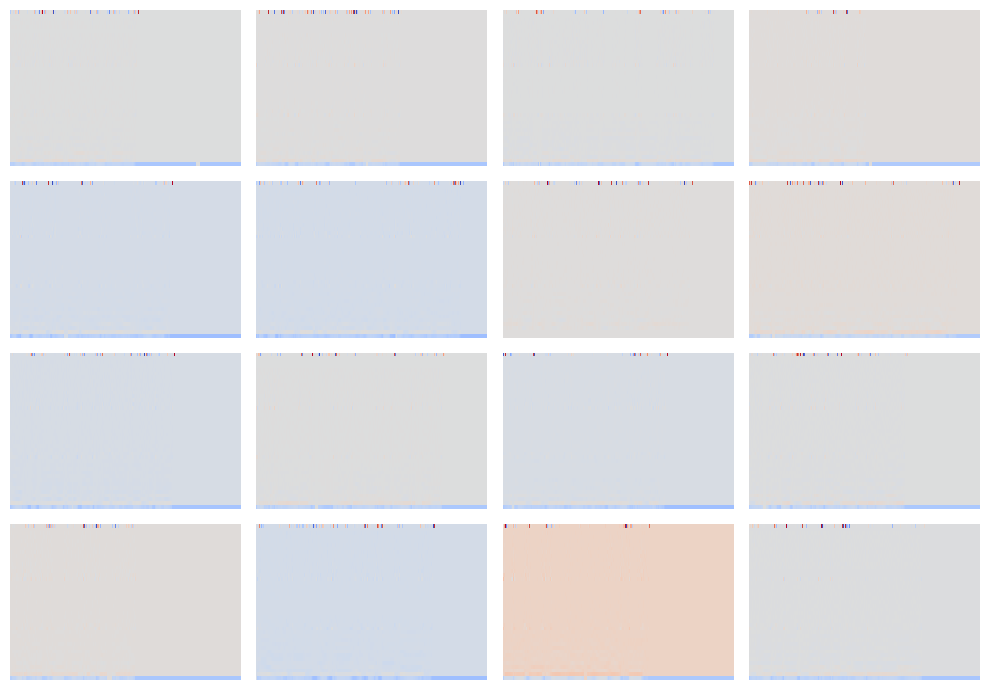

In [15]:
train = train.unbatch().batch(16)
spectrogram = next(iter(train))[0]['audio']

plt.figure(figsize=(10, 7))
n_samples = spectrogram.shape[0]
row = 4
col = int(n_samples / 4)

for i in range(n_samples):
    plt.subplot(row, col, i+1)
    plt.axis("off")
    librosa.display.specshow(
        np.transpose(spectrogram[i].numpy()), 
        sr=args.sample_rate,
        hop_length=args.hop_length)

plt.tight_layout()
plt.show()

# Model

Model: "Segmentor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
audio (InputLayer)              [(None, 400, 41, 1)] 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 400, 39, 128) 512         audio[0][0]                      
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 400, 39, 128) 0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 400, 39, 128) 512         time_distributed_1[0][0]         
__________________________________________________________________________________________

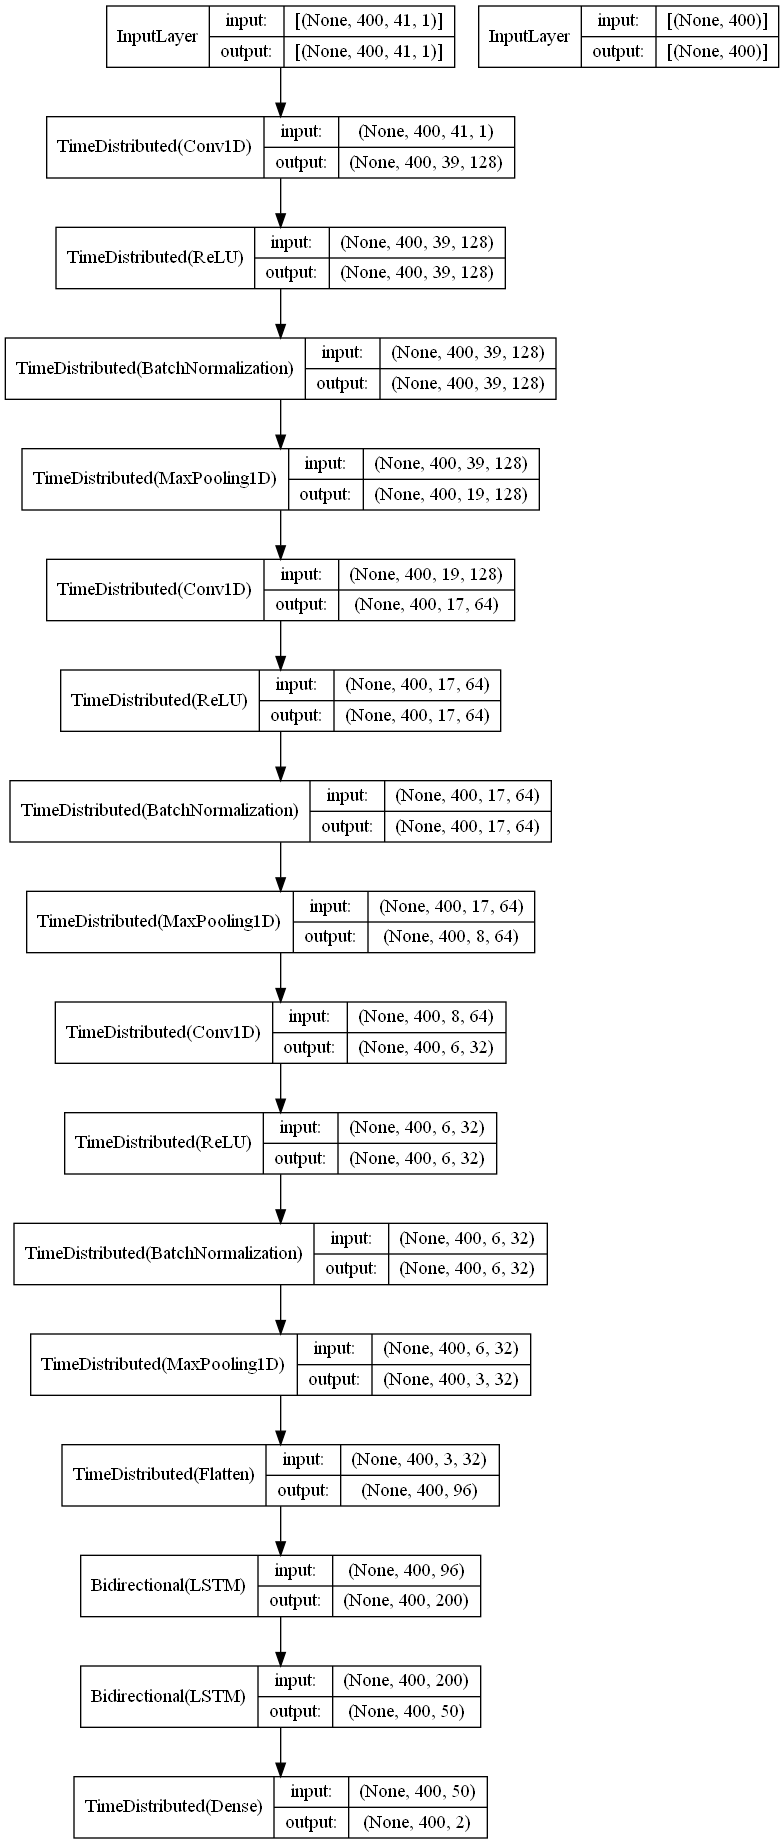

In [16]:
def Segmentor(args):
    spectrogram = Input(shape=args.input_shape, dtype=tf.float32, name='audio')
    mask = Input(shape=args.input_shape[0], dtype=tf.bool, name='mask')

    x = TimeDistributed(Conv1D(128, 3))(spectrogram)
    x = TimeDistributed(ReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPool1D(2))(x)

    x = TimeDistributed(Conv1D(64, 3))(x)
    x = TimeDistributed(ReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPool1D(2))(x)

    x = TimeDistributed(Conv1D(32, 3))(x)
    x = TimeDistributed(ReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPool1D(2))(x)
    
    x = TimeDistributed(Flatten())(x)
    x = Bidirectional(LSTM(100, dropout=args.dropout, return_sequences=True))(x, mask=mask)
    x = Bidirectional(LSTM(25, dropout=args.dropout, return_sequences=True))(x, mask=mask)
    x = TimeDistributed(Dense(2, activation='softmax'))(x, mask=mask)
    return Model(inputs=[spectrogram, mask], outputs=x, name='Segmentor')

model = Segmentor(args)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=False, show_dtype=False)

In [17]:
class SegmentorTrainer():
    def __init__(self, args):
        self.args = args
        self.model = Segmentor(args)
        self.dataloader = DataLoader(args)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=args.learning_rate)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(
            from_logits=False, label_smoothing=0.2)
        self.metric = tfa.metrics.F1Score(args.n_classes, 'micro')
    
    def train(self):
        for epoch in range(self.args.epochs):
            stateful_metrics = ['loss', 'f1', 'val_loss', 'val_f1']
            print(f"Epoch {epoch+1}/{self.args.epochs}")
            progbar = tf.keras.utils.Progbar(
                self.args.train_steps, interval=0.05,
                stateful_metrics=stateful_metrics)
            for step, (X_train, y_train) in enumerate(self.dataloader.train):
                labels = y_train['labels']
                t_mask = tf.cast(X_train['mask'], dtype=tf.float32)
                t_mask = tf.tile(
                    tf.expand_dims(t_mask, axis=-1), [1,1,self.args.n_classes])
                with tf.GradientTape() as tape:
                    t_logits = model(X_train, training=True)
                    t_loss = self.loss_fn(labels, t_logits)
                grads = tape.gradient(t_loss, model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                self.metric.update_state(labels, t_logits, sample_weight=t_mask)
                t_f1 = self.metric.result()
                progbar.update(
                    step, values=[('loss', t_loss), ('f1', t_f1)],
                    finalize=False)
                self.metric.reset_states()

            for X_val, y_val in self.dataloader.val:
                labels = y_val['labels']
                v_mask = tf.cast(X_val['mask'], dtype=tf.float32)
                v_mask = tf.tile(
                    tf.expand_dims(v_mask, axis=-1), [1,1,self.args.n_classes])
                v_logits = model(X_val, training=False)
                v_loss = self.loss_fn(labels, v_logits)
                self.metric.update_state(labels, v_logits, sample_weight=v_mask)
            values = [
                ('loss', t_loss), ('f1', t_f1), ('val_loss', v_loss),
                ('val_f1', self.metric.result())]
            progbar.update(self.args.train_steps, values=values, finalize=True)
            self.metric.reset_states()
        model.save_weights("model_weights/segmentor.h5", overwrite=True)
        return model

# model = SegmentorTrainer(args).train()

## Load weights

In [18]:
model.load_weights("model_weights\segmentor.h5")

In [19]:
idx = 0
sample = next(iter(val))
y_pred = model.predict(val)[idx]
y_true = sample[1]['labels'][idx]
F1 = tfa.metrics.F1Score(2, "weighted")(y_true, y_pred).numpy()
print("F1:", F1)

F1: 0.79464006


In [20]:
p = tf.math.argmax(y_pred, axis=-1).numpy()
p = np.squeeze(np.where(p==1))
p = [(p[i], p[i+1]) for i, b in enumerate(p) if i < len(p) - 1]
print(p)

[(2, 4), (4, 5), (5, 13), (13, 14), (14, 28), (28, 29), (29, 34), (34, 42), (42, 43), (43, 57), (57, 66), (66, 67), (67, 77), (77, 78), (78, 85), (85, 86), (86, 90), (90, 91), (91, 100), (100, 101), (101, 103), (103, 104), (104, 113), (113, 116), (116, 117), (117, 123), (123, 128), (128, 129), (129, 136), (136, 145), (145, 146), (146, 151), (151, 152), (152, 164), (164, 165), (165, 179), (179, 180), (180, 192), (192, 193), (193, 195), (195, 196), (196, 200), (200, 201), (201, 215), (215, 216), (216, 222), (222, 231), (231, 232), (232, 263), (263, 264), (264, 265)]


In [21]:
y = tf.math.argmax(y_true, axis=-1).numpy()
y = np.squeeze(np.where(y==1))
y = [(y[i], y[i+1]) for i, b in enumerate(y) if i < len(y) - 1]
print(y)

[(2, 3), (3, 4), (4, 8), (8, 9), (9, 18), (18, 19), (19, 27), (27, 28), (28, 34), (34, 35), (35, 51), (51, 52), (52, 55), (55, 56), (56, 66), (66, 67), (67, 78), (78, 79), (79, 84), (84, 85), (85, 93), (93, 94), (94, 104), (104, 105), (105, 107), (107, 108), (108, 116), (116, 117), (117, 118), (118, 120), (120, 121), (121, 128), (128, 129), (129, 149), (149, 150), (150, 156), (156, 157), (157, 166), (166, 167), (167, 173), (173, 174), (174, 178), (178, 179), (179, 190), (190, 191), (191, 195), (195, 196), (196, 200), (200, 201), (201, 205), (205, 206), (206, 212), (212, 213), (213, 220), (220, 221), (221, 237), (237, 238), (238, 259), (259, 260), (260, 274), (274, 275), (275, 276)]


## Inference loop

In [22]:
def ArgParser():
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--wav_path", default="videoplayback_16k.wav")
    parser.add_argument("--sample_rate", dest="sample_rate", type=int, default=16000)
    parser.add_argument("--n_fft", dest="n_fft", type=int, default=2048)
    parser.add_argument("--window_size", dest="window_size", type=int, default=400) # 25ms
    parser.add_argument("--hop_length", dest="hop_length", type=int, default=160) # 10ms
    parser.add_argument("--n_mels", dest="n_mels", type=int, default=64)
    parser.add_argument("--n_mfcc", dest="n_mfcc", type=int, default=13)
    parser.add_argument("--max_samples", dest="max_samples", type=int, default=64000)
    parser.add_argument("--delta_width", dest="delta_width", type=int, default=3)
    parser.add_argument("--dropout", dest="dropout", type=float, default=0.5)
    parser.add_argument("--verbose", dest="verbose", type=int, default=1)

    parser.add_argument("--mag_rate", dest="mag_rate", type=float, default=0.3)
    parser.add_argument("--grad_limit", dest="grad_limit", type=float, default=0.2)
    parser.add_argument("--benchmark_mul", dest="benchmark_mul", type=float, default=0.1)
    
    args = parser.parse_known_args()[0]
    seq_len = int(np.ceil(args.max_samples / args.hop_length))
    input_shape = (seq_len, (args.n_mfcc * 3) + 2, 1)
    parser.add_argument("--input_shape", type=tuple, default=input_shape)
    parser.add_argument("--seq_len", type=int, default=seq_len)
    return parser.parse_known_args()[0]

args = ArgParser()
args

Namespace(benchmark_mul=0.1, delta_width=3, dropout=0.5, grad_limit=0.2, hop_length=160, input_shape=(400, 41, 1), mag_rate=0.3, max_samples=64000, n_fft=2048, n_mels=64, n_mfcc=13, sample_rate=16000, seq_len=400, verbose=1, wav_path='videoplayback_16k.wav', window_size=400)

Predicted word boundaries: []


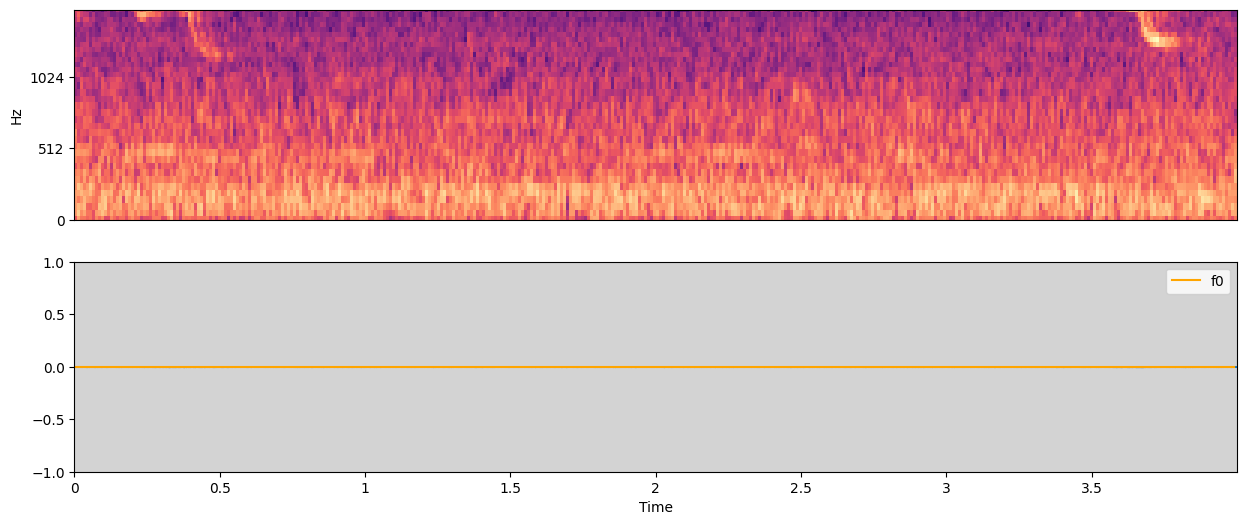

Predicted word boundaries: [(0, 50), (52, 60), (66, 68), (78, 81), (85, 117), (229, 250), (256, 300), (344, 380)]


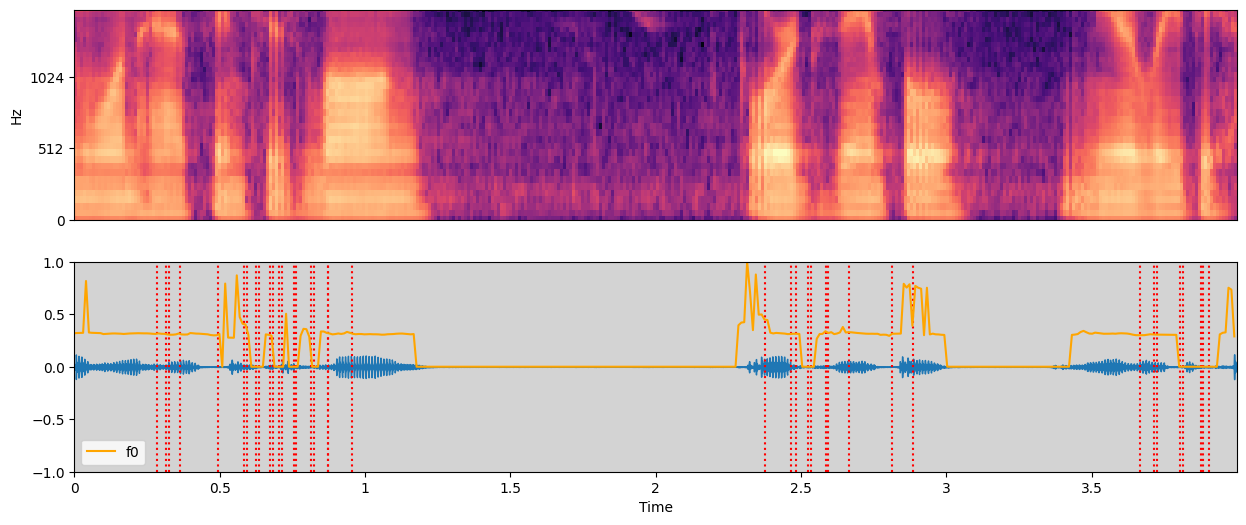

In [23]:
class MonoTracker:
    def __init__(self, args):
        self.args = args
        self.segmentor = self.Segmentor(args)

    def Segmentor(self, args):
        spectrogram = Input(shape=args.input_shape, dtype=tf.float32, name='audio')
        mask = Input(shape=args.input_shape[0], dtype=tf.bool, name='mask')

        x = TimeDistributed(Conv1D(128, 3))(spectrogram)
        x = TimeDistributed(ReLU())(x)
        x = TimeDistributed(BatchNormalization())(x)
        x = TimeDistributed(MaxPool1D(2))(x)

        x = TimeDistributed(Conv1D(64, 3))(x)
        x = TimeDistributed(ReLU())(x)
        x = TimeDistributed(BatchNormalization())(x)
        x = TimeDistributed(MaxPool1D(2))(x)

        x = TimeDistributed(Conv1D(32, 3))(x)
        x = TimeDistributed(ReLU())(x)
        x = TimeDistributed(BatchNormalization())(x)
        x = TimeDistributed(MaxPool1D(2))(x)
        
        x = TimeDistributed(Flatten())(x)
        x = Bidirectional(LSTM(100, dropout=args.dropout, return_sequences=True))(x, mask=mask)
        x = Bidirectional(LSTM(25, dropout=args.dropout, return_sequences=True))(x, mask=mask)
        x = TimeDistributed(Dense(2, activation='softmax'))(x, mask=mask)
        model = Model(inputs=[spectrogram, mask], outputs=x, name='Segmentor')
        model.load_weights("model_weights\segmentor.h5")
        return model

    def AudioPrep(self, y):
        mfcc = librosa.feature.mfcc(
            y=y, sr=self.args.sample_rate, n_mfcc=self.args.n_mfcc, hop_length=self.args.hop_length,
            win_length=self.args.window_size, n_mels=self.args.n_mels,
            n_fft=self.args.n_fft, fmin=0, fmax=8000)[:, :self.args.seq_len]
        mfcc = np.transpose(mfcc)
        delta = librosa.feature.delta(
            mfcc, width=self.args.delta_width, order=1, axis=0)
        delta2 = librosa.feature.delta(
            mfcc, width=self.args.delta_width, order=2, axis=0)
        zcr = librosa.feature.zero_crossing_rate(
            y=y, frame_length=self.args.window_size, hop_length=self.args.hop_length)
        zcr =  np.transpose(zcr)[:-1, :]
        f0 = librosa.yin(y=y, sr=self.args.sample_rate, fmin=50, fmax=2000, win_length=self.args.window_size,
            hop_length=self.args.hop_length, frame_length=2048)
        f0 = np.expand_dims(np.diff(f0, axis=-1), axis=-1)
        mfcc = np.concatenate((mfcc, delta, delta2, zcr, f0), axis=-1)
        mfcc = tf.convert_to_tensor(mfcc, dtype=tf.float32)
        mfcc = tf.expand_dims(mfcc, axis=0)
        
        n_frames = len(y) // self.args.hop_length
        pad_length = self.args.seq_len - n_frames 
        mask = tf.concat([tf.ones([n_frames]), tf.zeros([pad_length])], axis=-1)
        mask = tf.cast(mask, dtype=tf.bool)
        mask = tf.expand_dims(mask, axis=0)    
        return {"audio": mfcc, "mask": mask}

    def MakeChunks(self, wav_path):
        # Resample
        y, sr = librosa.load(wav_path, sr=None)
        if sr != self.args.sample_rate:
            y = librosa.resample(
                y, orig_sr=sr, target_sr=self.args.sample_rate)
        chunk_length = self.args.hop_length * self.args.seq_len
        self.chunk_duration = chunk_length // self.args.sample_rate
        n_chunks = len(y) // chunk_length
        y = y[:(n_chunks * chunk_length)]
        y_chunks = np.array_split(y, n_chunks)
        return y_chunks

    def ChunkGenerator(self, wav_path):
        y_chunks = self.MakeChunks(wav_path)
        self.n_chunks = len(y_chunks)
        for y_chunk in y_chunks:
            if len(y_chunk) <= self.args.max_samples:     
                y_chunk = librosa.util.fix_length(
                    y_chunk, self.args.max_samples)
            yield y_chunk

    def predict(self, y_chunk):
        inputs = self.AudioPrep(y_chunk)
        y_pred = self.segmentor.predict(inputs)[0]
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.squeeze(np.where(y_pred==1))
        y_pred = [(y_pred[i].numpy(), y_pred[i+1].numpy()) for i, b in enumerate(y_pred) if i < len(y_pred) - 1]
        y_pred = [frames for frames in y_pred if ((frames[1] - frames[0]) >= 2) & ((frames[1] - frames[0] <= 10))]
        return y_pred
    
    def batch_predict(self, wav_path):
        false_counter, true_counter = 0, 0
        forward, residual, benchmark = 0, 0, 0
        total_mono, total_voiced, mean = 0, 0, 0
        chunks = []
        for i, y_chunk in enumerate(self.ChunkGenerator(wav_path)):
            total = 0
            start_time = time.time()
            y_pred = self.predict(y_chunk)
            if y_pred != [(2, 397)]:
                f0 = librosa.yin(
                    y=y_chunk, sr=self.args.sample_rate, fmin=50, fmax=2000, 
                    win_length=self.args.window_size,
                    hop_length=self.args.hop_length, frame_length=2048)
                voiced_flag = self.get_voiced_flags(y_chunk, y_pred)
                voiced_sum = voiced_flag.sum()
            else: 
                voiced_sum = 0

            if voiced_sum == 0:
                if self.args.verbose == 1:
                    print("{}/{} - No speech detected.".format(i+1, self.n_chunks))
                false_counter += 1
                pass
            else:
                words = self.extract_words(voiced_flag)
                for j, word in enumerate(words):
                    start_idx, end_idx = word
                    length = end_idx - start_idx
                    mean = np.mean(f0[start_idx:end_idx])
                    delta = np.abs(mean - residual)
                    if length > 1:
                        grad = np.abs(np.mean(np.gradient(f0[start_idx:end_idx], edge_order=1)))
                    else:
                        grad = 1
                    if forward == 0:
                        buffer = len(words) // 2
                    if ((forward == 0) & (j < buffer) | (delta > benchmark * self.args.benchmark_mul)):
                        benchmark += (mean / buffer)
                    else:
                        if (benchmark * self.args.mag_rate > delta) & (grad > self.args.grad_limit):
                            total += length
                    residual = mean
                forward = mean
                voiced_ratio = voiced_sum / len(voiced_flag)
                elapsed_time = time.time() - start_time
                mono_ratio = total / voiced_sum

                if mono_ratio >= 0.3:
                    if true_counter == 0:
                        chunk_start = i * self.chunk_duration
                    else:
                        false_counter = 0
                    mono_block = True
                    true_counter += 1
                else:
                    mono_block = False
                    false_counter += 1
                    if (false_counter >= 1) & (true_counter > 0):
                        true_counter = 0
                        false_counter = 0
                        chunks.append([chunk_start, i * self.chunk_duration])

                if self.args.verbose == 1:
                    print("{}/{} - voiced_ratio: {:.2f}% - words: {} - monotonic_frames: {} - monotonic_ratio: {:.2f}% - elapsed_time: {:.2f}s".format(
                        i+1, self.n_chunks, voiced_ratio*100, len(words), total, mono_ratio*100, elapsed_time))    
            total_mono += total
            total_voiced += voiced_sum
        mono_ratio = (total_mono / total_voiced) * 100
        return mono_ratio, chunks

    def extract_words(self, voiced_flag):
        word, words = [], []
        for i, j in enumerate(voiced_flag):
            if j == True:
                word.append(i)
            else:
                if len(word) > 1:
                    word = (word[0], word[-1])
                    words.append(word)
                word = []
        return words

    def get_voiced_flags(self, y, pred_frames):
        zcr = librosa.feature.zero_crossing_rate(y, hop_length=args.hop_length)[0] 
        zcr = np.abs(np.gradient(zcr))
        zcr = np.less(zcr, zcr.mean())
        rms = librosa.feature.rms(y, hop_length=args.hop_length)[0] 
        rms = np.greater(rms, rms.mean())
        frames = np.zeros(len(zcr), dtype=int)
        for start_idx, end_idx in pred_frames:
            frames[start_idx:end_idx] = 1
        frames = np.logical_and(frames, zcr)
        if sum(frames) != 0:
            frames = np.logical_or(frames, rms)
        return frames

    def Plotter(self, wav_path, chunk_id):
        y_chunk = self.MakeChunks(wav_path)[chunk_id]
        if len(y_chunk) <= self.args.max_samples:
            y_chunk = librosa.util.fix_length(y_chunk, self.args.max_samples)
        y_pred = self.predict(y_chunk)

        fig, ax = plt.subplots(2, 1, figsize=(15,6))     

        # Mel-Spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y_chunk, sr=self.args.sample_rate, n_fft=self.args.n_fft, 
            hop_length=self.args.hop_length, win_length=self.args.window_size, 
            center=False, n_mels=self.args.n_mels)  
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        librosa.display.specshow(
            mel_spec, sr=self.args.sample_rate, ax=ax[0], y_axis='mel')
        ax[0].set_ylim(0, 2000)
        
        # Waveplot
        librosa.display.waveplot(y_chunk, sr=args.sample_rate, ax=ax[1])

        for i, frame in enumerate(y_pred):
            frame = librosa.frames_to_time(frame, sr=self.args.sample_rate, 
            hop_length=self.args.hop_length, n_fft=self.args.n_fft)
            ax[1].vlines(x=frame, ymin=-1, ymax=1, colors='red', 
            linestyles='dotted')        

        voiced_flags = self.get_voiced_flags(y_chunk, y_pred)
        words = self.extract_words(voiced_flags)
        print("Predicted word boundaries:", words)
        f0 = librosa.yin(
            y_chunk, fmin=librosa.note_to_hz('G2'), fmax=librosa.note_to_hz('A4'),
            win_length=self.args.window_size, hop_length=self.args.hop_length)
        f0 = (f0 * voiced_flags) / f0.max()
        duration = librosa.get_duration(y_chunk, sr=self.args.sample_rate)
        times = np.arange(0, duration, step=(duration / voiced_flags.shape[0]))      
        ax[1].set_ylim(-1, 1)
        ax[1].plot(times, f0, color="orange", label="f0")
        ax[1].set_facecolor('lightgrey')
        ax[1].legend()
        plt.show()

alg = MonoTracker(args)
for chunk_id in [1, 61]:
    alg.Plotter(wav_path=args.wav_path, chunk_id=chunk_id)

In [24]:
alg.batch_predict(wav_path=args.wav_path)

1/636 - No speech detected.
2/636 - No speech detected.
3/636 - No speech detected.
4/636 - No speech detected.
5/636 - No speech detected.
6/636 - No speech detected.
7/636 - No speech detected.
8/636 - No speech detected.
9/636 - voiced_ratio: 15.96% - words: 2 - monotonic_frames: 0 - monotonic_ratio: 0.00% - elapsed_time: 0.21s
10/636 - voiced_ratio: 38.90% - words: 5 - monotonic_frames: 87 - monotonic_ratio: 55.77% - elapsed_time: 0.22s
11/636 - voiced_ratio: 37.66% - words: 3 - monotonic_frames: 98 - monotonic_ratio: 64.90% - elapsed_time: 0.21s
12/636 - voiced_ratio: 42.89% - words: 7 - monotonic_frames: 107 - monotonic_ratio: 62.21% - elapsed_time: 0.21s
13/636 - voiced_ratio: 38.15% - words: 8 - monotonic_frames: 57 - monotonic_ratio: 37.25% - elapsed_time: 0.24s
14/636 - voiced_ratio: 45.14% - words: 8 - monotonic_frames: 134 - monotonic_ratio: 74.03% - elapsed_time: 0.21s
15/636 - voiced_ratio: 37.16% - words: 8 - monotonic_frames: 108 - monotonic_ratio: 72.48% - elapsed_time

(80.21117348302593,
 [[36, 152],
  [156, 720],
  [724, 820],
  [824, 1108],
  [1112, 1148],
  [1152, 1244],
  [1252, 1328],
  [1332, 1540],
  [1544, 1836],
  [1840, 1968],
  [1972, 2008],
  [2012, 2232],
  [2236, 2528]])